In [76]:
from collections import namedtuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

well_5_5 = pd.read_csv('15_5-5.dat', index_col=0)

parameters = {
            "rho": {"o": 0.8, "b": 1.0, "sandstone": 2.65},
            "vp": {"o": 4500, "b": 4500},
            "vs": {"o": 3100, "b": 3050}}


def change_porosity(dp, lith_param, lithology="sandstone"):
    dvp_b = -dp*lith_param["vp"]["b"]
    dvp_o = -dp*lith_param["vp"]["o"]
    
    dvs_b = -dp*lith_param["vs"]["b"]
    dvs_o = -dp*lith_param["vs"]["o"]
    
    drho_b = -dp*(lith_param["rho"][lithology]-lith_param["rho"]["b"])
    drho_o = -dp*(lith_param["rho"][lithology]-lith_param["rho"]["o"])
    
    return {"dvp": {"o": dvp_o, "b": dvp_b},
            "dvs": {"o": dvs_o, "b": dvs_b},
            "drho": {"o": drho_o, "b": drho_b}}

def compute_incremental_sw_change(dsw, porosity_changes):
    dvp = dsw*porosity_changes["dvp"]["b"]+(1-dsw)*porosity_changes["dvp"]["o"]
    dvs = dsw*porosity_changes["dvs"]["b"]+(1-dsw)*porosity_changes["dvs"]["o"]
    drho = dsw*porosity_changes["drho"]["b"]+(1-dsw)*porosity_changes["drho"]["o"]   
    return {"dvp": dvp, "dvs": dvs, "drho": drho}

def change_water_saturation(dsw, block, incremental_sw_change):    
    vp_ = dsw*block.vp1+(1-dsw)*block.vp2 + incremental_sw_change["dvp"]
    vs_ = dsw*block.vs1+(1-dsw)*block.vs2 + incremental_sw_change["dvs"]
    rho_ = dsw*block.rho1+(1-dsw)*block.rho2 + incremental_sw_change["drho"]
    return {"vp": vp_, "vs": vs_, "rho": rho_}

class Block(object):
    def __init__(self, top, bottom, vp1, vp2, vs1, vs2, rho1, rho2, vp, vs, rho, md):
        self.top = top
        self.bottom = bottom
        self.vp1 = vp1
        self.vp2 = vp2
        self.vs1 = vs1
        self.vs2 = vs2
        self.rho1 = rho1
        self.rho2 = rho2

        self.vp = vp
        self.vs = vs
        self.rho = rho
        
        self.md = md
        self.depth_mod = 0

def define_block(well, top, bottom):
    z = well.index.values
    depth_indices = (well.index>=top) & (well.index<bottom)
    block_logs = well[depth_indices]
    block = Block(top, bottom, 
                  block_logs.VP_FRMB.mean(), block_logs.VP_FRMO.mean(),
                  block_logs.VS_FRMB.mean(), block_logs.VS_FRMO.mean(),
                  block_logs.RHO_FRMB.mean(), block_logs.RHO_FRMO.mean(),
                  block_logs.VP_FRMB.mean(), block_logs.VS_FRMB.mean(), block_logs.RHO_FRMB.mean(), block_logs.index)
    return block

def apply_block_changes(block, changes):
    block.vp = changes["vp"]
    block.vs= changes["vs"]
    block.rho = changes['rho']
    
def compute_block_changes(block, dp, dsw, lithology, parameters):
    porosity_change = change_porosity(dp, parameters, lithology=lithology)
    inc_sw_change = compute_incremental_sw_change(dsw, porosity_change)
    sw_change = change_water_saturation(dsw, block, inc_sw_change)
    return sw_change


def blocks_to_log(w, blocks, depth_modifiers):
    well = w.copy()
    well["VP"] = well.VP_FRMB
    well["VS"] = well.VS_FRMB
    well["RHO"] = well.RHO_FRMB
    
    for i, block in enumerate(blocks):
        depth_indices = (well.index>=block.top+depth_modifiers[i]) & (well.index<block.bottom+depth_modifiers[i+1])
        well.loc[depth_indices, "VP"] = np.ones(well[depth_indices]["VP"].values.shape[0])*block.vp
        well.loc[depth_indices, "VS"] = np.ones(well[depth_indices]["VS"].values.shape[0])*block.vs
        well.loc[depth_indices, "RHO"] = np.ones(well[depth_indices]["RHO"].values.shape[0])*block.rho
    return well

top_blocks = [2000, 2050, 2154, 2200, 2224, 2234, 2280, 2300, 2800]
depth_mod = [0]*(len(top_blocks)+1)
depth_mod[2] = 10
blocks = []
for i in range(1, len(top_blocks)):
    blocks.append(define_block(well_5_5, top_blocks[i-1], top_blocks[i]))

for block in blocks:
    changes = compute_block_changes(block, 0.0, 0.0, "sandstone", parameters)
    apply_block_changes(block, changes)
    
pseudo_well_zero = blocks_to_log(well_5_5, blocks, [0]*(len(top_blocks)+1))
pseudo_well = blocks_to_log(well_5_5, blocks, depth_mod)

Text(0.5,1,'RHO')

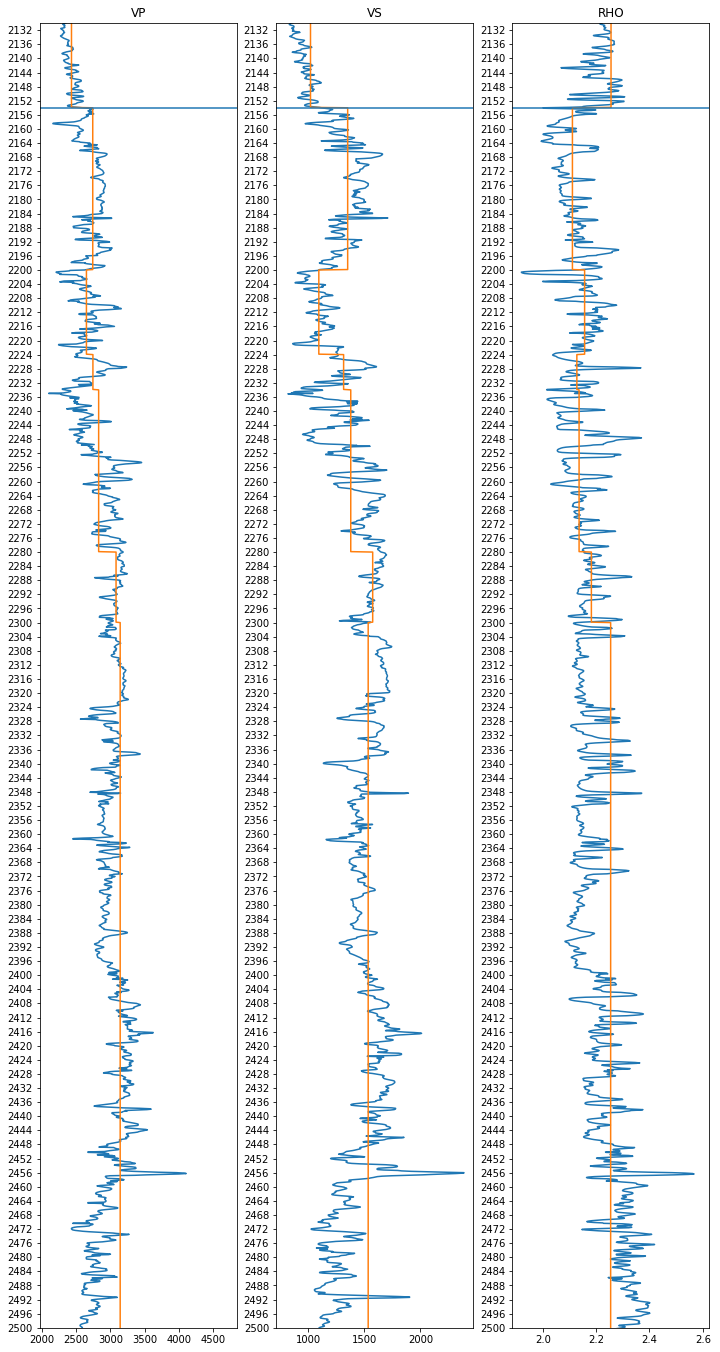

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(12, 24))
ax[0].plot(well_5_5.VP_FRMO, well_5_5.index)
ax[0].plot(pseudo_well_zero.VP, pseudo_well_zero.index)

ax[1].plot(well_5_5.VS_FRMO, well_5_5.index)
ax[1].plot(pseudo_well_zero.VS, pseudo_well_zero.index)

ax[2].plot(well_5_5.RHO_FRMO, well_5_5.index)
ax[2].plot(pseudo_well_zero.RHO, pseudo_well_zero.index)

for i in range(3):
    ax[i].set_ylim(2500, 2130)
    ax[i].yaxis.set_major_locator(MaxNLocator(100))
    ax[i].axhline(2154)
ax[0].set_title("VP")
ax[1].set_title("VS")
ax[2].set_title("RHO")

Text(0.5,1,'RHO')

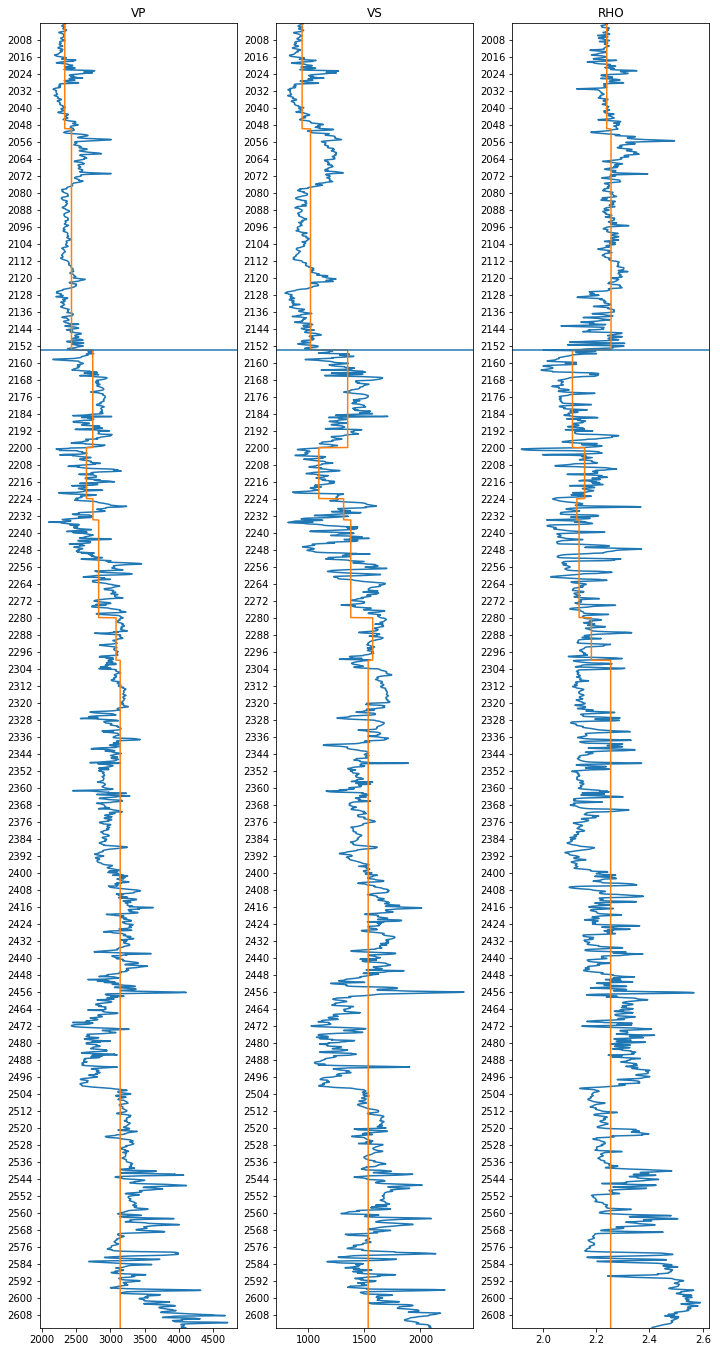

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(12, 24))
ax[0].plot(well_5_5.VP_FRMO, well_5_5.index)
ax[0].plot(pseudo_well_zero.VP, pseudo_well_zero.index)

ax[1].plot(well_5_5.VS_FRMO, well_5_5.index)
ax[1].plot(pseudo_well_zero.VS, pseudo_well_zero.index)

ax[2].plot(well_5_5.RHO_FRMO, well_5_5.index)
ax[2].plot(pseudo_well_zero.RHO, pseudo_well_zero.index)

for i in range(3):
    ax[i].set_ylim(well_5_5.index.max(), well_5_5.index.min())
    ax[i].yaxis.set_major_locator(MaxNLocator(100))
    ax[i].axhline(2154)
ax[0].set_title("VP")
ax[1].set_title("VS")
ax[2].set_title("RHO")

Text(0.5,1,'RHO')

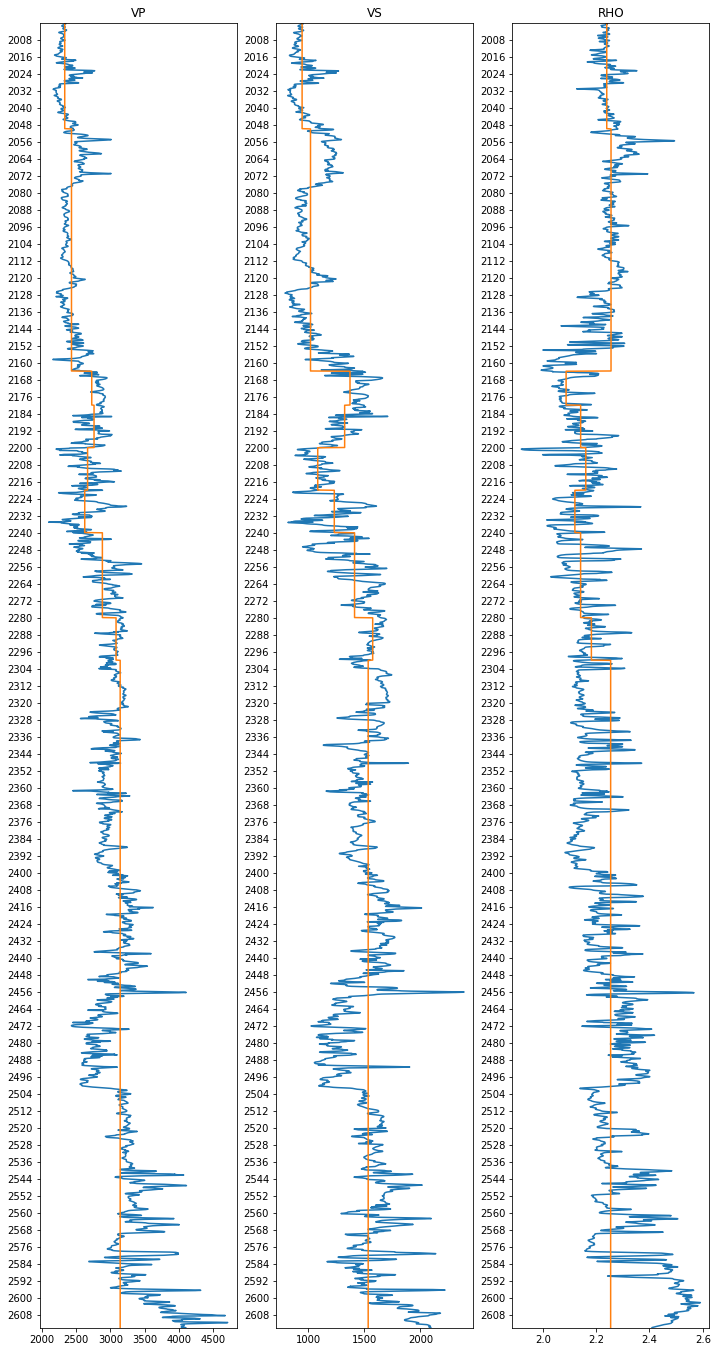

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(12, 24))
ax[0].plot(well_5_5.VP_FRMO, well_5_5.index)
ax[0].plot(pseudo_well.VP, pseudo_well.index)

ax[1].plot(well_5_5.VS_FRMO, well_5_5.index)
ax[1].plot(pseudo_well.VS, pseudo_well.index)

ax[2].plot(well_5_5.RHO_FRMO, well_5_5.index)
ax[2].plot(pseudo_well.RHO, pseudo_well.index)

for i in range(3):
    ax[i].set_ylim(well_5_5.index.max(), well_5_5.index.min())
    ax[i].yaxis.set_major_locator(MaxNLocator(100))
ax[0].set_title("VP")
ax[1].set_title("VS")
ax[2].set_title("RHO")




Text(0.5,1,'Difference')

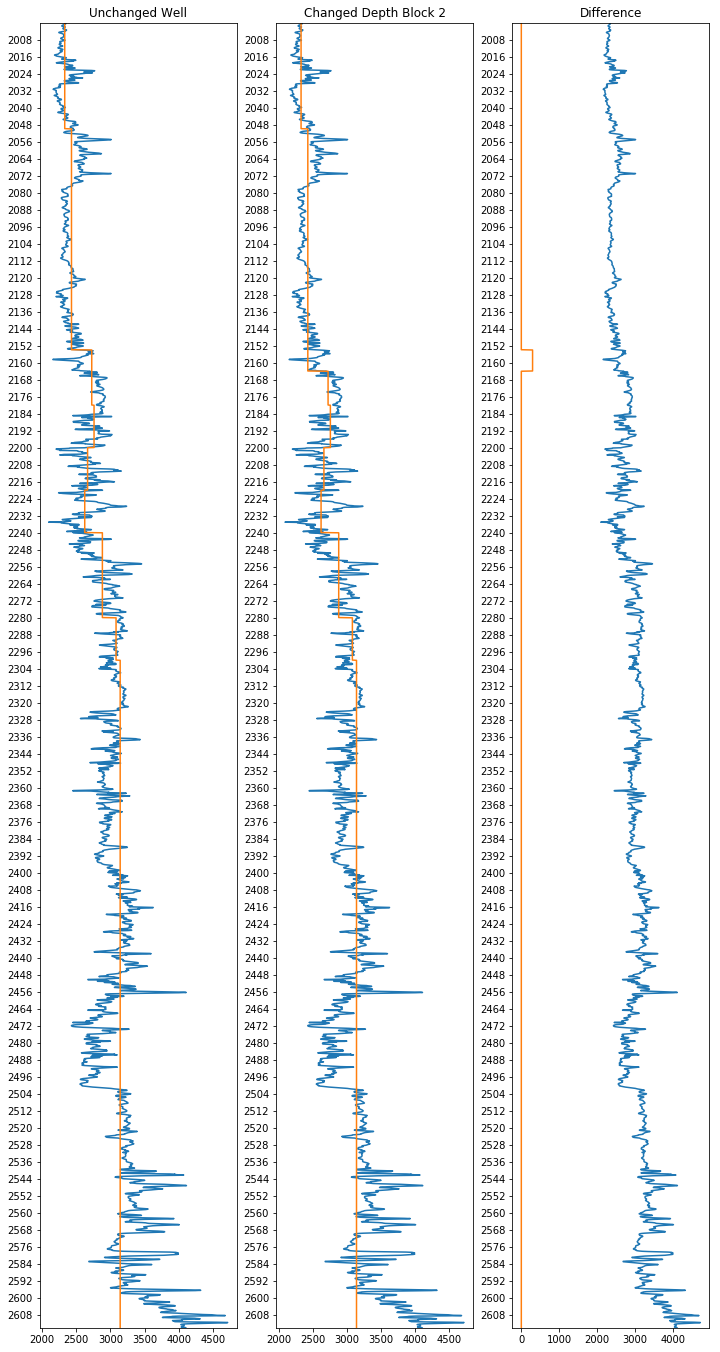

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(12, 24))
ax[0].plot(well_5_5.VP_FRMO, well_5_5.index)
ax[0].plot(pseudo_well_zero.VP, pseudo_well_zero.index)

ax[1].plot(well_5_5.VP_FRMO, well_5_5.index)
ax[1].plot(pseudo_well.VP, pseudo_well.index)

ax[2].plot(well_5_5.VP_FRMO, well_5_5.index)
ax[2].plot(pseudo_well_zero.VP - pseudo_well.VP, pseudo_well.index)

for i in range(3):
    ax[i].set_ylim(well_5_5.index.max(), well_5_5.index.min())
    ax[i].yaxis.set_major_locator(MaxNLocator(100))
    
ax[0].set_title("Unchanged Well")
ax[1].set_title("Changed Depth Block 2")
ax[2].set_title("Difference")

In [4]:
import bruges as b
import asap_library as hl

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
dt=.004
wavl=b.filters.ricker(.25, dt, 30)
ang=np.linspace(5,30,2)

In [89]:
print(hl.get_twt(tdr_w2, 2500))

2.8444673380097285


In [6]:
w2=pd.read_csv('qsiwell2.csv', index_col=0)
w3=pd.read_csv('qsiwell3.csv', index_col=0)
w5=pd.read_csv('qsiwell5.csv', index_col=0)

wells=    [ w2,       w3,       w5]
names=     ['15/5-5','15/5-3', '15/5-6']

tops_w2={'Lista': 2127, 'Heimdal': 2154}
tops_w3={'Lista': 2153, 'Heimdal': 2180}
tops_w5={'Lista': 2145, 'Heimdal': 2172}
tops=pd.DataFrame()
for i,val in enumerate([tops_w2,tops_w3,tops_w5]):
    tempdf=pd.DataFrame.from_dict(val, orient='index')
    tempdf.columns=[names[i]]
    tops=pd.concat([tops, tempdf],axis=1)

In [7]:
tdr_w2=hl.td(w2,KB=26,WD=109)
topres_w2=hl.get_twt(tdr_w2,tops['15/5-5']['Heimdal'])

tdr_w3=hl.td(w3,KB=26,WD=109)
topres_w3=hl.get_twt(tdr_w2,tops['15/5-3']['Heimdal'])

tdr_w5=hl.td(w5,KB=26,WD=109)
topres_w5=hl.get_twt(tdr_w5,tops['15/5-6']['Heimdal'])

[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2013.253 [m] = 2.495 [s]
[TD] computed twt scale range: 2.495-2.926 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 200.150 [m] = 0.229 [s]
[TD] computed twt scale range: 0.229-3.625 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2100.072 [m] = 2.604 [s]
[TD] computed twt scale range: 2.604-2.754 [s]


In [8]:
tdr, topres = tdr_w2, topres_w2

t1=topres-0.048
t2=topres+0.208

In [78]:
nnt,_,_ = hl.welltime(pseudo_well_zero, tdr, dt=dt, qcplot=False)
rc,synt=hl.make_synt(nnt, ang, wavl, method='aki')
outdf = nnt[(nnt.index>=t1) & (nnt.index<=t2)].copy()
it1=np.abs(nnt.index-t1).argmin()
it2=np.abs(nnt.index-t2).argmin()
synt_cut = synt[it1:it2,:]
print(len(synt_cut))
outdf['NEAR'] = synt_cut[:,0]
outdf['FAR'] = synt_cut[:,1]

64


In [79]:
outdf.head()

,DEPTH,VP_FRMB,VS_FRMB,RHO_FRMB,PHIE,VSH,VP_FRMO,VS_FRMO,RHO_FRMO,VP,VS,RHO,NEAR,FAR
TWT,,,,,,,,,,,,,,
2.568,2100.822816,2374.236336,982.142656,2.281113,0.223722,0.954941,2374.236336,982.142656,2.281113,2429.415852,1018.341144,2.255582,-9.318905e-06,-6.444357e-06
2.572,2105.563679,2345.594939,938.818238,2.247388,0.244688,0.804182,2345.594939,938.818238,2.247388,2429.415852,1018.341144,2.255582,-8.431432e-07,-5.826416e-07
2.576,2110.183740,2305.395791,878.544529,2.232478,0.253981,0.922232,2305.395791,878.544529,2.232478,2429.415852,1018.341144,2.255582,-7.283920e-08,-4.034120e-08
2.580,2114.912341,2425.447700,1002.186149,2.284719,0.221467,0.930295,2425.447700,1002.186149,2.284719,2429.415852,1018.341144,2.255582,-2.983251e-07,-3.053873e-08
2.584,2119.814871,2461.950488,1150.011466,2.288743,0.218897,0.850383,2461.950488,1150.011466,2.288743,2429.415852,1018.341144,2.255582,-3.816589e-06,-3.698638e-07


(2.2, 3.0)

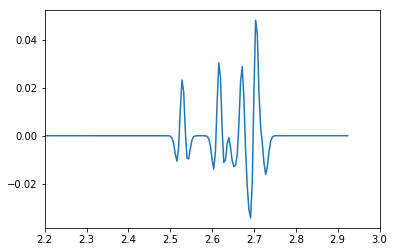

In [80]:
nnt,_,_ = hl.welltime(pseudo_well_zero, tdr, dt=dt, qcplot=False)
rc,synt=hl.make_synt(nnt, ang, wavl, method='aki')
plt.plot(np.arange(synt.shape[0])*dt, synt[:, 0])
plt.xlim(2.2, 3.0)

In [81]:
near_trace_at_well = np.load("./near_well_5_5.npy")

Text(0.5,1,'diff L2')

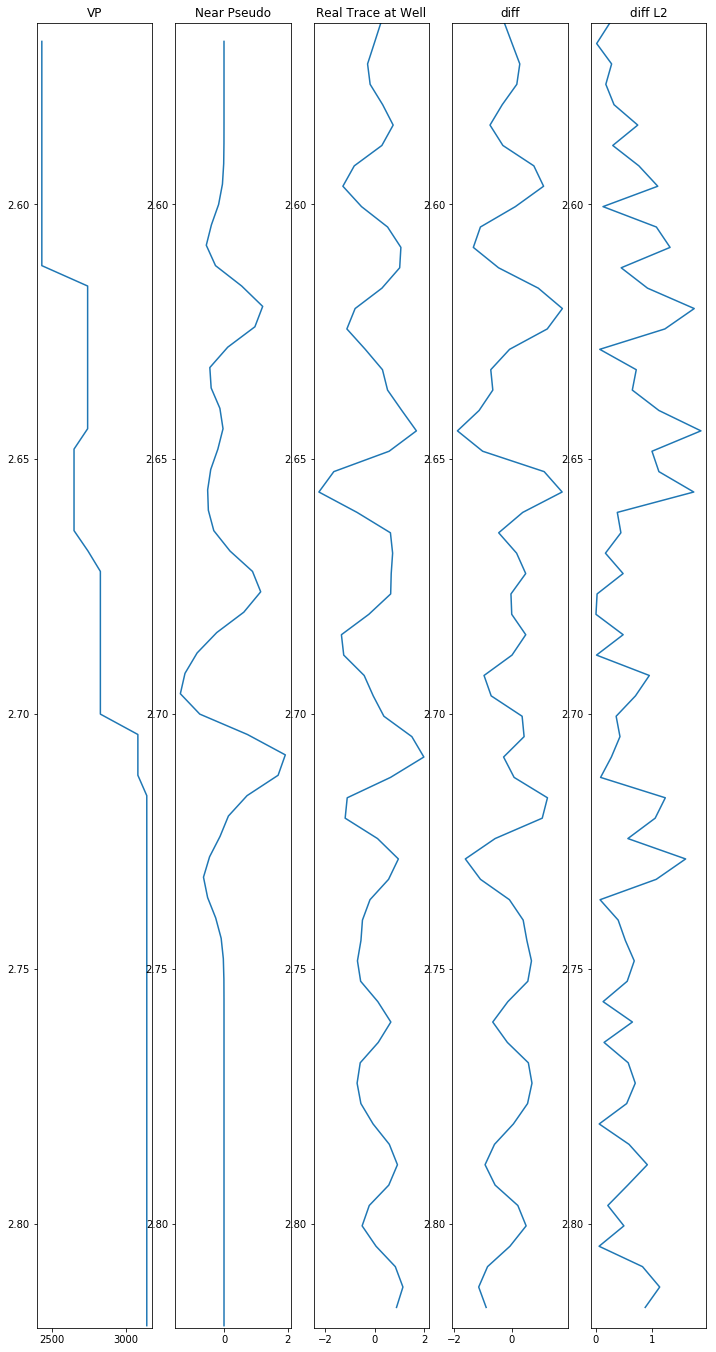

In [82]:
fig, ax = plt.subplots(1, 5, figsize=(12, 24))
ax[0].plot(outdf.VP, outdf.index)
ax[1].plot(outdf.NEAR*2/0.05, outdf.index)
ax[2].plot(near_trace_at_well, t1+np.array(range(len(near_trace_at_well)))*dt)
ax[3].plot(outdf.NEAR*2/0.05-near_trace_at_well, t1+np.array(range(len(near_trace_at_well)))*dt)
ax[4].plot(np.sqrt(np.power(outdf.NEAR*2/0.05-near_trace_at_well, 2)), t1+np.array(range(len(near_trace_at_well)))*dt)
for i in range(5):
    ax[i].set_ylim(t2, t1)
ax[0].set_title("VP")
ax[1].set_title("Near Pseudo")
ax[2].set_title("Real Trace at Well")
ax[3].set_title("diff")
ax[4].set_title("diff L2")


Text(0.5,1,'diff L2')

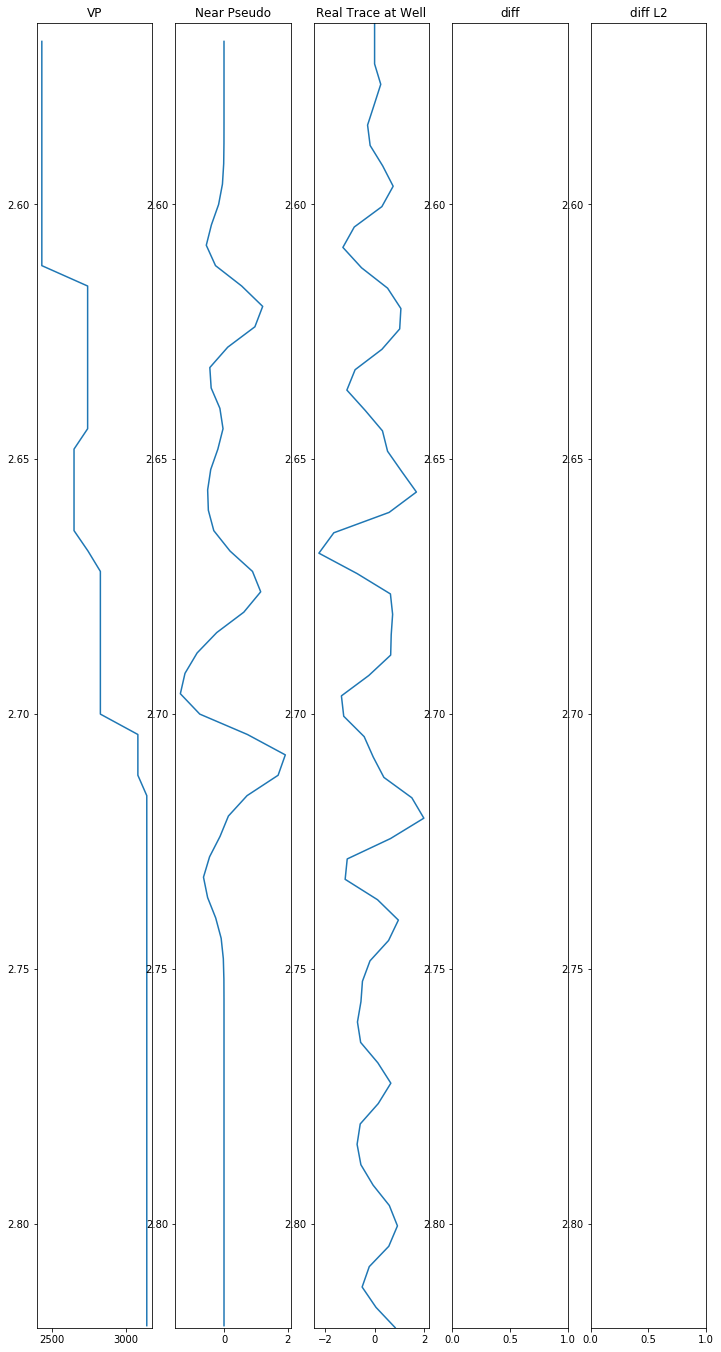

In [83]:
near_trace_at_well = np.zeros(64+3)
near_trace_at_well[3:] = np.load("./near_well_5_5.npy")

fig, ax = plt.subplots(1, 5, figsize=(12, 24))
ax[0].plot(outdf.VP, outdf.index)
ax[1].plot(outdf.NEAR*2/0.05, outdf.index)
ax[2].plot(near_trace_at_well, t1+np.array(range(len(near_trace_at_well)))*dt)
#ax[3].plot(outdf.NEAR*2/0.05-near_trace_at_well, t1+np.array(range(len(near_trace_at_well)))*dt)
#ax[4].plot(np.sqrt(np.power(outdf.NEAR*2/0.05-near_trace_at_well, 2)), t1+np.array(range(len(near_trace_at_well)))*dt)
for i in range(5):
    ax[i].set_ylim(t2, t1)
ax[0].set_title("VP")
ax[1].set_title("Near Pseudo")
ax[2].set_title("Real Trace at Well")
ax[3].set_title("diff")
ax[4].set_title("diff L2")